In [1]:
%tensorflow_version 2.x


TensorFlow 2.x selected.


In [38]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import glob
import IPython.display as display
from PIL import Image
import keras.backend.tensorflow_backend as K

keras = tf.keras

ModuleNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/RecycleSort/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/RecycleSort


In [0]:
data_dir = pathlib.Path('/gdrive/My Drive/RecycleSort/recyclesort_dataset/Train')

In [10]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
image_count

1261

In [11]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('Train/*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Paper', 'MetalCans', 'Cardboard'], dtype='<U9')

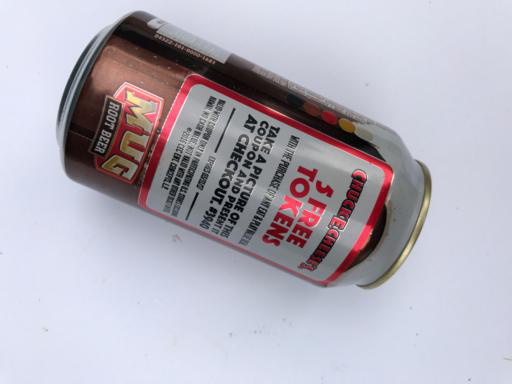

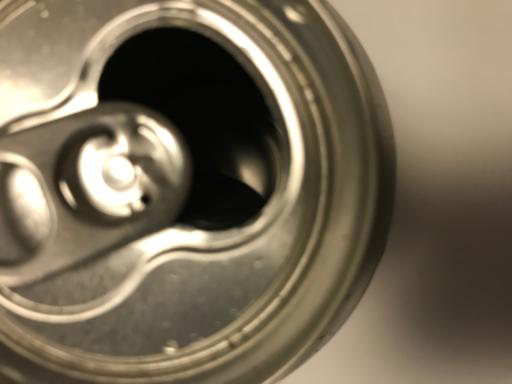

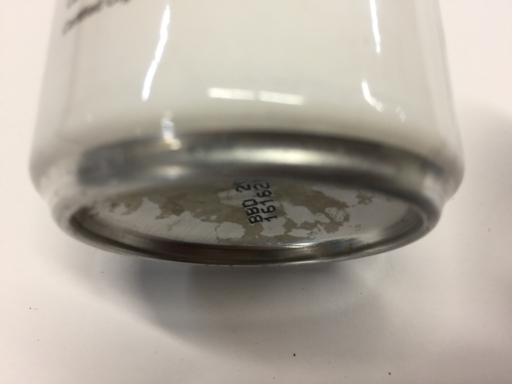

In [12]:
cans = list(data_dir.glob('Train/MetalCans/*'))

for image_path in cans[:3]:
    display.display(Image.open(str(image_path)))

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [15]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/Train',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

validation_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/Validation',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1002 images belonging to 3 classes.
Found 259 images belonging to 3 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

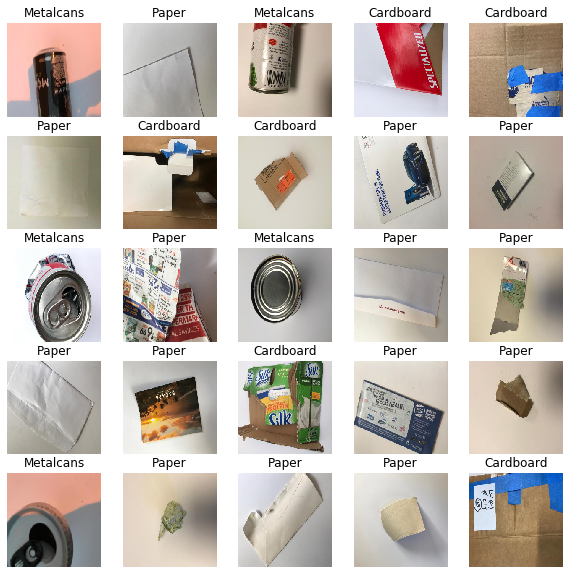

In [17]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [18]:
image_batch.shape

(32, 224, 224, 3)

**Model**

In [19]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [20]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [21]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [0]:
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])

In [0]:
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
len(model.trainable_variables)

2

**Train Model**

In [28]:
initial_epochs = 20
validation_steps = 4

loss0, accuracy0 = model.evaluate(validation_data_gen, steps = validation_steps)

  ...
    to  
  ['...']
4/4 [==============================] - 30s 7s/step - loss: 1.5275 - accuracy: 0.2969


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.53
initial accuracy: 0.30


In [30]:
history = model.fit_generator(train_data_gen,
                    epochs=initial_epochs, validation_data = validation_data_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 9 steps
Epoch 1/20
32/32 [==============================] - 320s 10s/step - loss: 1.1288 - accuracy: 0.4242 - val_loss: 0.9818 - val_accuracy: 0.5019
Epoch 2/20
32/32 [==============================] - 5s 166ms/step - loss: 0.8766 - accuracy: 0.5948 - val_loss: 0.8162 - val_accuracy: 0.6409
Epoch 3/20
32/32 [==============================] - 6s 177ms/step - loss: 0.7144 - accuracy: 0.7016 - val_loss: 0.7041 - val_accuracy: 0.6873
Epoch 4/20
32/32 [==============================] - 5s 172ms/step - loss: 0.6086 - accuracy: 0.7575 - val_loss: 0.6482 - val_accuracy: 0.7066
Epoch 5/20
32/32 [==============================] - 5s 171ms/step - loss: 0.5308 - accuracy: 0.8134 - val_loss: 0.6231 - val_accuracy: 0.7259
Epoch 6/20
32/32 [==============================] - 5s 170ms/step - loss: 0.4735 - accuracy: 0.8423 - val_loss: 0.5939 - va

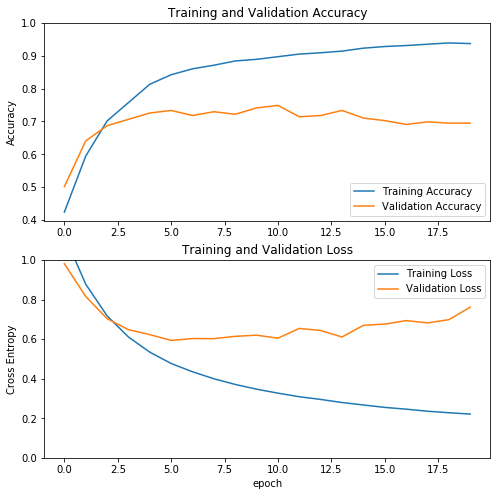

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine-Tuning** (if required)

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [0]:
model.summary()

In [0]:
len(model.trainable_variables)

In [0]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Save Model**

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("object_model.h5")

**Export Model to tflite**

In [39]:
output_names = [node.op.name for node in model.outputs]
sess = tf.keras.backend.get_session()
frozen_def = tf.graph_util.convert_variables_to_constants(
    sess, sess.graph_def, output_names)

AttributeError: ignored